In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from pearce.mocks.kittens import TrainingBox, MDPL2
import numpy as np
from scipy.optimize import minimize_scalar
from halotools.mock_observables import hod_from_mock
from astropy.table import Table
import h5py

/home/users/swmclau2/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


I tried putting an HOD on the MDPL2 box and recovering it, but my result was very biased. Now i want to understand wtf is the problem. 

In [3]:
galcat = np.load('/home/users/swmclau2/scratch/UniverseMachine/hod_catalog2.npy')
#galcat = np.load('/home/users/swmclau2/scratch/UniverseMachine/cut_nfwized_sham_catalog.npy')

In [4]:
true_hod_params = {'alpha': 1.083, 'logM0': 13.2, 'logM1': 14.2, 'sigma_logM': 0.2}
true_hod_params['logMmin'] = 13.0 # TODO fit nd

nd = 5e-4
min_ptcl = 100

In [5]:
def add_logMmin(cat, params, nd):
    def func(logMmin, hod_params):
        params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(params, min_ptcl=min_ptcl) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (params,), options = {'maxiter':100}, method = 'Bounded')

     # assuming this doens't fail
    print 'logMmin', res.x
    params['logMmin'] = res.x

In [6]:
cat = TrainingBox(10)
cat.load(1.0, HOD='zheng07')

In [7]:
add_logMmin(cat, true_hod_params, nd)

logMmin 13.067362624055738


In [8]:
cat.populate(true_hod_params, min_ptcl=min_ptcl)

In [9]:
len(cat.model.mock.galaxy_table)

579576

In [10]:
cat.calc_analytic_nd()

0.0004951524663504945

In [11]:
len(galcat)

499787

In [12]:
galcat.dtype

dtype([('halo_upid', '<i8'), ('halo_hostid', '<i8'), ('conc_NFWmodel', '<f4'), ('halo_y', '<f4'), ('halo_x', '<f4'), ('halo_z', '<f4'), ('halo_vx', '<f4'), ('halo_vy', '<f4'), ('halo_vz', '<f4'), ('halo_rvir', '<f4'), ('halo_mvir', '<f4'), ('halo_id', '<i8'), ('halo_num_centrals', '<i4'), ('halo_num_satellites', '<i4'), ('gal_type', 'O'), ('vx', '<f4'), ('host_centric_distance', '<f8'), ('vy', '<f4'), ('y', '<f4'), ('x', '<f4'), ('vz', '<f4'), ('z', '<f4')])

In [13]:
mass_bins = np.logspace(11, 16, 61)
mbc = (mass_bins[1:]+mass_bins[:-1])/2.0

In [14]:
aemulus_cenmask = cat.model.mock.galaxy_table['gal_type'] == 'centrals'

In [15]:
aemulus_hod = hod_from_mock(cat.model.mock.galaxy_table[aemulus_cenmask]['halo_mvir'], cat.model.mock.halo_table['halo_mvir'], mass_bins)[0]

In [16]:
cat2 = MDPL2()

In [17]:
f = h5py.File('/home/users/swmclau2/scratch/hlists/hlist_1.00.list.mdpl2.hdf5')

In [18]:
len(f['data'])

127388160

In [19]:
rvirs = []
for i in xrange(0, len(f['data']), int(1e6)):
    print i
    data = f['data'][i:i+int(1e6)]
    rvirs.append(data[np.logical_and(data['halo_mvir']>np.min(galcat['halo_mvir']),\
                                     data['halo_upid']==-1)]['halo_rvir'])

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000
100000000
101000000
102000000
103000000
104000000
105000000
106000000
107000000
108000000
109000000
110000000
111000

In [20]:
f.close()

In [21]:
mdpl2_rvirs2 = np.concatenate(rvirs)

In [22]:
catalog_fname = '/home/users/swmclau2/scratch/test_MDPL2_halo_vpeak_smf_sham_large.hdf5'

#halos = np.fromfile(catalog_fname, dtype=um_dtype)
mdpl2_halos = np.array(Table.read(catalog_fname, format = 'hdf5'))

In [23]:
mdpl2_host_halos = mdpl2_halos[np.logical_and(mdpl2_halos['halo_mvir']>np.min(galcat['halo_mvir']), mdpl2_halos['halo_upid']==-1)]

In [24]:
mdpl2_cenmask = galcat['gal_type'] == 'centrals'

In [25]:
mdpl2_hod = hod_from_mock(galcat[mdpl2_cenmask]['halo_mvir'], mdpl2_host_halos['halo_mvir'], mass_bins)[0]

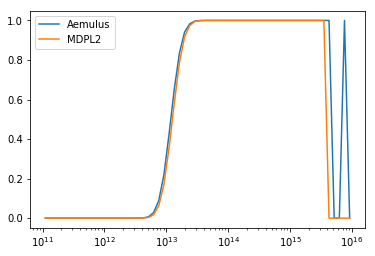

In [26]:
plt.plot(mbc, aemulus_hod, label = 'Aemulus')
plt.plot(mbc, mdpl2_hod, label = 'MDPL2')
plt.legend(loc='best')
#plt.loglog()
plt.xscale('log')

In [27]:
aemulus_host_halos = cat.halocat.halo_table[np.logical_and(\
                        cat.halocat.halo_table['halo_mvir']>np.min(cat.model.mock.halo_table['halo_mvir']),
                        cat.halocat.halo_table['halo_upid']==-1)]

In [28]:
aemulus_conc = aemulus_host_halos['halo_nfw_conc']
aemulus_mass = aemulus_host_halos['halo_mvir']

idxs = np.logical_and(np.isfinite(aemulus_conc), ~np.isnan(aemulus_conc))
aemulus_conc = aemulus_conc[idxs]
aemulus_mass = aemulus_mass[idxs]

In [29]:
mdpl2_mass = mdpl2_host_halos['halo_mvir']
mdpl2_conc = mdpl2_host_halos['halo_rvir']/mdpl2_host_halos['halo_rs']

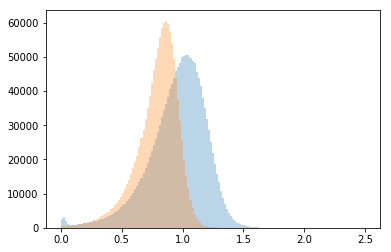

In [30]:
bins = np.linspace(0, 2.5, 150)
plt.hist(np.log10(aemulus_conc), bins = bins, alpha = 0.3);
plt.hist(np.log10(mdpl2_conc), bins = bins, alpha = 0.3);

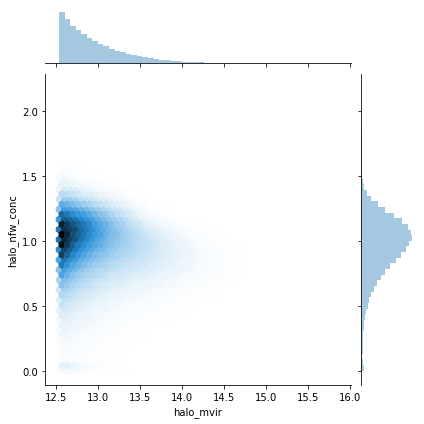

In [31]:
sns.jointplot(np.log10(aemulus_mass), np.log10(aemulus_conc), kind='hex')

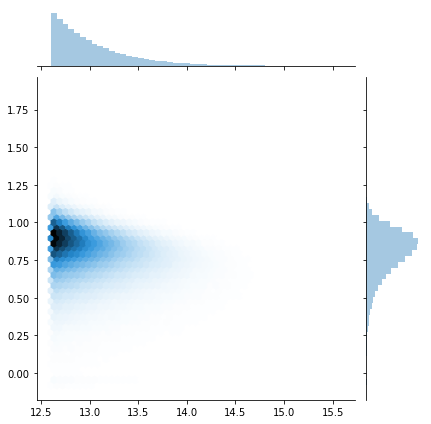

In [32]:
sns.jointplot(np.log10(mdpl2_mass), np.log10(mdpl2_conc), kind = 'hex')

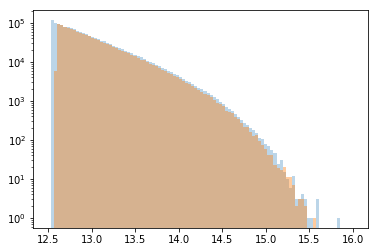

In [33]:
bins = np.linspace(12.5,16,101)
plt.hist(np.log10(aemulus_mass), bins = bins, alpha = 0.3);
plt.hist(np.log10(mdpl2_mass), bins = bins , alpha = 0.4);

plt.yscale('log')

In [34]:
mdpl2_hcd = galcat['host_centric_distance']
mdpl2_hcd = mdpl2_hcd[mdpl2_hcd>0]

In [35]:
aemulus_hcd = cat.model.mock.galaxy_table['host_centric_distance']
aemulus_hcd = aemulus_hcd[aemulus_hcd>0]

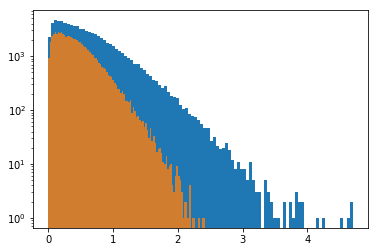

In [36]:
plt.hist(aemulus_hcd, bins = 100);
plt.hist(mdpl2_hcd, bins = 100, alpha = 0.8)
plt.yscale('log')

In [37]:
mdpl2_rs = mdpl2_host_halos['halo_rs']

In [38]:
aemulus_rs = aemulus_host_halos['halo_rs']

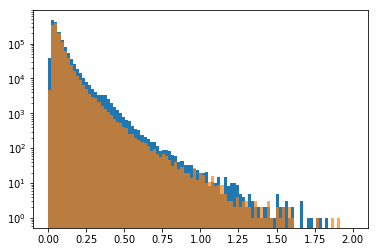

In [39]:
bins = np.linspace(0, 2, 100)
plt.hist(aemulus_rs, bins = bins);
plt.hist(mdpl2_rs, bins = bins, alpha = 0.7);
plt.yscale('log')

In [40]:
mdpl2_rvir = mdpl2_host_halos['halo_rvir']

In [41]:
aemulus_rvir = aemulus_host_halos['halo_rvir'] # remember, actually r200b

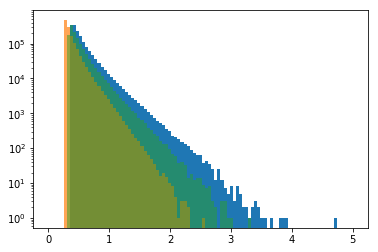

In [42]:
bins = np.linspace(0, 5, 100)
plt.hist(aemulus_rvir, bins = bins);
plt.hist(mdpl2_rvir, bins = bins, alpha = 0.7)
plt.hist(mdpl2_rvirs2, bins=bins, alpha = 0.5)
#plt.hist(mdpl2_rvir3, bins = bins, alpha = 0.5)
plt.yscale('log')

In [43]:
np.all(np.isclose(mdpl2_rvir, mdpl2_rvirs2))

False

In [54]:
np.power(0.677, -2.0/3)

1.2970027220326676

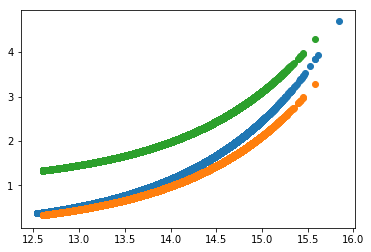

In [70]:
plt.scatter(np.log10(aemulus_host_halos['halo_mvir']), aemulus_rvir)
#plt.scatter(np.log10(mdpl2_host_halos['halo_mvir']), mdpl2_host_halos['halo_rvir'])
plt.scatter(sorted(np.log10(mdpl2_host_halos['halo_mvir'])), sorted(mdpl2_rvirs2) )
plt.scatter(np.log10(mdpl2_m200b), mdpl2_rvirs3+1)

In [45]:
import astropy.constants as const
from astropy import units as u

In [66]:
def mass_to_r(halo_masses):
     return np.cbrt( (const.G*const.M_sun/(67.7*u.km/u.s/u.Mpc)**2)*halo_masses/100).to('Mpc').value


In [47]:
f = h5py.File('/home/users/swmclau2/scratch/hlists/hlist_1.00.list.mdpl2.hdf5')

In [59]:
m200bs = []
for i in xrange(0, len(f['data']), int(1e6)):
    print i
    data = f['data'][i:i+int(1e6)]
    m200bs.append(data[np.logical_and(data['halo_mvir']>np.min(galcat['halo_mvir']),\
                                     data['halo_upid']==-1)]['halo_mvir'])

0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
33000000
34000000
35000000
36000000
37000000
38000000
39000000
40000000
41000000
42000000
43000000
44000000
45000000
46000000
47000000
48000000
49000000
50000000
51000000
52000000
53000000
54000000
55000000
56000000
57000000
58000000
59000000
60000000
61000000
62000000
63000000
64000000
65000000
66000000
67000000
68000000
69000000
70000000
71000000
72000000
73000000
74000000
75000000
76000000
77000000
78000000
79000000
80000000
81000000
82000000
83000000
84000000
85000000
86000000
87000000
88000000
89000000
90000000
91000000
92000000
93000000
94000000
95000000
96000000
97000000
98000000
99000000
100000000
101000000
102000000
103000000
104000000
105000000
106000000
107000000
108000000
109000000
110000000
111000

In [60]:
mdpl2_m200b = np.concatenate(m200bs)

In [67]:
mdpl2_rvirs3 = mass_to_r(mdpl2_m200b)

In [68]:
mdpl2_m200b

array([1.9495e+14, 1.6469e+14, 1.4017e+14, ..., 4.0676e+12, 4.2347e+12,
       4.0360e+12], dtype=float32)